# Classification

Now before we begin, thev guy speaks about a lot of different ocncepts as to just name drop them or to make you prepared for what you might see in the future.

Please, please, plleeeeeaaaaase understand them. UNDERSTAND THEM.

# 1. Getting the dataset

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
x, y = mnist["data"], mnist["target"]

In [3]:
x.shape

(70000, 784)

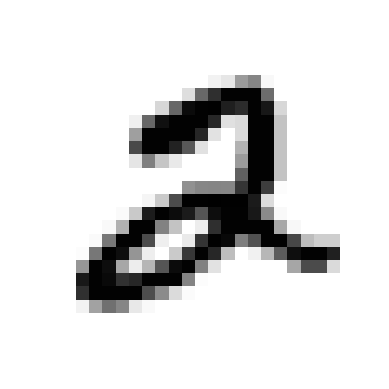

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = x.iloc[5].to_numpy()
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [5]:
y.iloc[5]

'2'

See how the label is a string? we need to cast it to a number

In [6]:
import numpy as np

y = y.astype(np.uint8)

Again, notice how your the distribution of your data is. It's important to know how your data is distributed.

In [7]:
y.value_counts()

class
1    7877
7    7293
3    7141
2    6990
9    6958
0    6903
6    6876
8    6825
4    6824
5    6313
Name: count, dtype: int64

# 2. Creating the training and validation sets

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(x, y):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [9]:
x_train.shape

(56000, 784)

In [10]:
y_train.shape

(56000,)

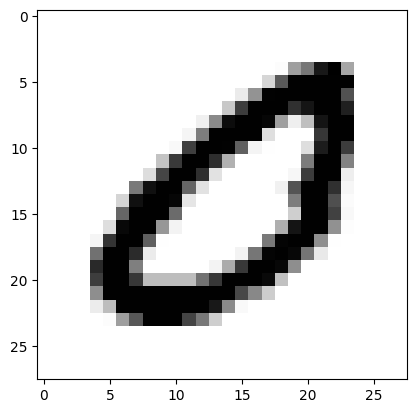

In [11]:
x_train.iloc[0].to_numpy().reshape(28, 28)
plt.imshow(x_train.iloc[0].to_numpy().reshape(28, 28), cmap="binary")

In [12]:
y_train.iloc[0]

0

# 3. Training a binary classifier

When it comes to classification with more classical ml models, we can try many binary classifiers for each label. So for example, for this MNIST dataset we can train a 5-detector, a 3-detector, a 9-detector, etc.

In [13]:
y_train_5 = y_train == 5
y_test_5 = y_test == 5

In [14]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(x_train, y_train_5)

SGDClassifier(random_state=42)

## Lets start cross validation

What is cross validation and what does it do? It's a way to evaluate your model. It's a way to see how well your model generalizes to new data.

How it works:
- The dataset is split into K equallt sized subsets or "folds".
- Iterative process: the model is trained and tested K times. In each iteration:
    - The model is trained on K-1 folds
    - The model is tested on the remaining fold
- Performance measurement: the model's performance is evaluated on the test fold in each iteration. 
- Averaging the results: The final performance estimate is teh average of the K iterations.

Why is it important:
1. Reliable performance estimation: Cross-validation provides a more reliable performance estimate than a single train-test split.
2. Reduced overfitting: Cross-validation reduces the risk of overfitting by testing the model on different subsets of the data.
3. Optimal model selection: It allows for comparing different models or hyperparameters to choose the best performing option
4. Efficient use of data: It makes the most of limited data by using each sample for both training and testing
5. Insight into model stability: The variation in performance across folds can indicate how stable or sensitive the model is to different data subsets.

Cross-validation is particularly useful when working with smaller datasets or when you want to ensure your model will perform well on unseen data.

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(x_train, y_train_5):
    clone_clf = clone(sgd_clf)
    x_train_folds = x_train.iloc[train_index]
    y_train_folds = y_train_5.iloc[train_index]
    x_test_fold = x_train.iloc[test_index]
    y_test_fold = y_train_5.iloc[test_index]

    clone_clf.fit(x_train_folds, y_train_folds)
    y_pred = clone_clf.predict(x_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.967214871163015
0.9571436224353137
0.96849887495982


In [16]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, x_train, y_train_5, cv=3, scoring="accuracy")

array([0.96721487, 0.95714362, 0.96849887])

YAY! we got 96% accuracy. But wait, is it really that good? is 96% accuracy a high performance on this dataset? Consider this mon ami:

Your dataset is now a binary dataset. The original dataset had somewhata uniform distribution for each label. So when you turned it into a binary dataset, over 90% of the data is now labeled as "not 5". So if you were to create a model that just says "not 5" for every image, you would get a 90% accuracy. So 96% accuracy is not that good.

So, enter CONFUSION MATRIX

## Confusion Matrix

A much better way to evaluate the performance of a classifier is to look at the confusion matrix. The general idea is to count the number of times instances of class A are classified as class B. For example, to know the number of times the classifier confused images of 5s with 3s, you would look in the 5th row and 3rd column of the confusion matrix.

In [17]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3)

In [18]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[50550,   400],
       [ 1600,  3450]])

Let us analyze what this means. This means that our classifier correctly clssified 50550 not five instances as not five, and 3450 instaces of fives as fives.

However, it incorrectly classified 400 instances of not fives as fives and 1600 instances of fives as not fives.

It is starting to get a bit daunting, right? So, enter PRECISION, RECALL, F1 SCORE

## Precision, Recall, F1 Score

The confudion matrix is goof doe us to understand what is going down in the classifier's performance, class by class, prediction by prediction. However, sometimes we need a more concise metric to evaluate the performance of a classifier. This is where precision, recall, and F1 score come in.


### Precision

Precision is the ratio of true positives (TP) to the sum of true positives and false positives (FP). It represents the accuracy of the positive predictions made by the classifier. In other more simpler words, it is the ratio of correctly predicted positive observations to the total predicted positive observations. Meaning that out of all the instances that the classifier predicted as positive, how many were actually positive.

```math
Precision = TP / (TP + FP)
```

### Recall

Recall is the ratio of true positives (TP) to the sum of true positives and false negatives (FN). It represents the ability of the classifier to find all the positive samples. In other more simpler words, it is the ratio of correctly predicted positive observations to the all observations in actual class. Meaning, that out of all of the model's predictions of a certain class, how many were correct?

```math
Recall = TP / (TP + FN)
```

### F1 Score

It is often convenient to combine precision and recall into a single metric called the F1 score. The F1 score is the harmonic mean of precision and recall. The harmonic mean is used here instead of the more traditional arithmetic mean because it punishes extreme values. The F1 score will be high only if both precision and recall are high. In other more simpler words, the F1 score is the weighted average of Precision and Recall. It takes both false positives and false negatives into account. It is a good way to balance the two metrics.

```math
F1 Score = 2 * (Precision * Recall) / (Precision + Recall)
```

A very good classifier will have a high precision and recall, and thus a high F1 score.

Now let's talk about one of the most important concepts in classification: the precision/recall tradeoff.

## Precision/Recall Tradeoff

In short, increasing the precision of a model means decreasing its recall and vice versa. This is called the precision/recall tradeoff. This is because the model is making a decision based on a threshold. If the threshold is high, the model will only predict instances that it is very sure about, which will increase precision but decrease recall. If the threshold is low, the model will predict more instances, which will increase recall but decrease precision.

### Key points:

1. Inverse relationship: As you increase precision, recall typically decreases, and vice versa.
2. Threshold dependence: The tradeoff is usually managed by adjusting the classification threshold in binary classification problems.
3. **No free lunch: It's generally impossible to have both perfect precision and perfect recall.**

### Why the tradeoff occurs:

- Increasing the classification threshold:
    - Improves precision (fewer false positives)
    - Reduces recall (more false negatives)

- Decreasing the classification threshold:
    - Improves recall (fewer false negatives)
    - Reduces precision (more false positives)



### Visualizing the tradeoff:
The Precision-Recall curve is a common way to visualize this tradeoff. It plots precision vs. recall at various threshold settings.
#### Choosing the right balance:
The optimal balance depends on your specific problem:

1. High precision (low recall) might be preferred when:
    - False positives are very costly
    - You need to be very confident in positive predictions
    - ***Example: Medical diagnosis for a rare, serious condition***

2. High recall (low precision) might be preferred when:

    - False negatives are very costly
    - You want to catch as many positive cases as possible
    - ***Example: Spam email detection***

3. Balanced approach:
    - F1 score: Harmonic mean of precision and recall
    - Can be used when you need a balance between precision and recall

### Real-world considerations:

1. Class imbalance: Can significantly affect the precision-recall tradeoff
2. Cost-sensitive learning: When different types of errors have different costs
3. Domain-specific requirements: Some fields may have regulatory or practical constraints on acceptable precision or recall levels

Understanding this tradeoff is crucial for:

Choosing appropriate evaluation metrics
Tuning model parameters effectively
Making informed decisions about model deployment



A good phrase to laways remember is that "if someone says lets reach a certain precision, ask them what recall they are willing to sacrifice"

## The ROC Curve

Another common tool that is used alongside binary calssifiers is the Reciever Operating Characterstic or the ROC curve. It is a plot of the true positive rate (recall) against the false positive rate. The false positive rate is the ratio of negative instances that are incorrectly classified as positive. It is equal to one minus the true negative rate, which is the ratio of negative instances that are correctly classified as negative. The true negative rate is also called specificity. Hence, the ROC curve plots sensitivity (recall) versus 1 - specificity.

```math
True Positive Rate (Recall) = TP / (TP + FN)
```

```math
False Positive Rate = FP / (FP + TN)
```

One thing to consider is the ROC curve is similar to the precision/recall curve so we may want to consider which one to use. As a rule of thumb, you should ***prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives. Otherwise, use the ROC curve.***


# Multiclass Classification

Here, we focus on handling multiclass classification problems with binary calssifiers. We can do it in two ways:
- One-versus-all (OvA) strategy: Train a binary classifier for each class, and select the class with the highest score for each instance.
- One-versus-one (OvO) strategy: Train a binary classifier for every pair of classes. If there are N classes, you need to train N * (N - 1) / 2 classifiers. The class that wins the most duels is the predicted class. ***The main advantage of OvO is that each classifier only needs to be trained on the part of the training set for the two classes that it must distinguish.***

Some algorithms like SVMs, scale poorly with the size of the training set, ***so for these algorithms OvO is preferred*** since it is faster to train many classifiers on small training sets than to train few classifiers on large training sets. For most binary classification algorithms, however, OvA is preferred.

NOW, scikit learn automatically detects when you try to use a binary classification algorithm for a multiclass classification task and it automatically runs OvA or OvO depending on the algorithm. So you don't have to worry about it.

In [20]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(x_train, y_train)

SVC()

In [21]:
svm_clf.predict([x_train.iloc[0].to_numpy()])

/Users/ahvra/miniforge3/envs/silica/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([0], dtype=uint8)

So what is happening here my friend? We are training a binary classifier for each digit. So we are training a 0-detector, a 1-detector, a 2-detector, etc. Then when we want to classify an image, we get the decision score from each classifier and we select the class whose classifier outputs the highest score. This is called the one-versus-all (OvA) strategy.
We can actually get the results for each classifier by calling the decision_function() method. It returns a score for each instance, for each class.

In [23]:
some_digit_scores = svm_clf.decision_function([x_train.iloc[0].to_numpy()])
some_digit_scores

/Users/ahvra/miniforge3/envs/silica/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([[9.31591458, 0.6972231 , 7.24258078, 4.80702459, 0.71036194,
        8.29130659, 6.08952842, 1.71926501, 3.92797165, 1.72637295]])

# Error Analysis

One of the most important parts of building a machine learning system is to analyze the errors that the model makes. This can often give you insights into what to do next to improve the model. For example, you might want to add more features, get rid of uninformative ones, or clean up the data.